## Setup and Imports

Import necessary libraries and set up the environment.

In [3]:
!pip install  typing langgraph langchain-openai langchain-core openai pillow ipython aiohttp python-dotenv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached msgpack-1.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 11.4 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 12.4 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
Using cached msgpack-1.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (403 kB)
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26305 sha256=6afb1ab769f53bc6e3c62db2a0163c06b5434eab10bceefd6da848b219b03c73
  Stored in directory: /home/laptop-obs-300/.cache/pip/wheels/9d/67/2f/53e3ef32ec48d11d7d60245255e2d71

In [4]:
import os
from typing import TypedDict, Annotated, Sequence, List
from langgraph.graph import Graph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from openai import OpenAI
from PIL import Image
import io
from IPython.display import display, Image as IPImage

from langchain_core.runnables.graph import MermaidDrawMethod

import asyncio
import aiohttp
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

# Initialize OpenAI client
client = OpenAI(api_key=api_key)

## Define Data Structures

Define the structure for the graph state using TypedDict.

In [6]:
class GraphState(TypedDict):
    messages: Annotated[Sequence[HumanMessage | AIMessage], "The messages in the conversation"]
    query: Annotated[str, "Input query describing the character and scene"]
    plot: Annotated[str, "Generated plot for the GIF"]
    character_description: Annotated[str, "Detailed description of the main character or object"]
    image_prompts: Annotated[List[str], "List of prompts for each frame"]
    image_urls: Annotated[List[str], "List of URLs for generated images"]
    gif_data: Annotated[bytes, "GIF data in bytes"]

# Initialize the language model
llm = ChatOpenAI(model="gpt-4",api_key=api_key)

## Define Graph Functions

Define the functions that will be used in the LangGraph workflow.

In [20]:
async def get_image_data(session, url: str):
    """Fetch image data from a given URL."""
    async with session.get(url) as response:
        if response.status == 200:
            return await response.read()
    return None

def generate_character_description(state: GraphState) -> GraphState:
    """Generate a detailed description of the main character or scene."""
    query = state["query"]
    response = llm.invoke([HumanMessage(content=f"Based on the query '{query}', create a detailed description of the main character, object, or scene. Include specific details about appearance, characteristics, and any unique features. This description will be used to maintain consistency across multiple images.")])
    state["character_description"] = response.content
    return state

def generate_plot(state: GraphState) -> GraphState:
    """Generate a 2-step plot for the GIF animation."""
    query = state["query"]
    character_description = state["character_description"]
    response = llm.invoke([HumanMessage(content=f"Create a short, 2-step plot for a GIF based on this query: '{query}' and featuring this description: {character_description}. Each step should be a brief description of a single frame, maintaining consistency throughout. Keep it family-friendly and avoid any sensitive themes.")])
    state["plot"] = response.content
    return state

def generate_image_prompts(state: GraphState) -> GraphState:
    """Generate specific image prompts for each frame of the GIF."""
    plot = state["plot"]
    character_description = state["character_description"]
    response = llm.invoke([HumanMessage(content=f"""Based on this plot: '{plot}' and featuring this description: {character_description}, generate 2 specific, family-friendly image prompts, one for each step. Each prompt should be detailed enough for image generation, maintaining consistency, and suitable for DALL-E. 

Always include the following in EVERY prompt to maintain consistency:
1. A brief reminder of the main character or object's key features
2. The specific action or scene described in the plot step
3. Any relevant background or environmental details

Format each prompt as a numbered list item, like this:
1. [Your prompt here]
2. [Your prompt here]
... and so on.""")])
    
    prompts = []
    for line in response.content.split('\n'):
        if line.strip().startswith(('1.', '2.', '3.', '4.', '5.')):
            prompt = line.split('.', 1)[1].strip()
            prompts.append(f"Create a detailed, photorealistic image of the following scene: {prompt}")
    
    # if len(prompts) != 5:
    #     raise ValueError(f"Expected 5 prompts, but got {len(prompts)}. Please try again.")
    
    state["image_prompts"] = prompts
    return state

async def create_image(prompt: str, retries: int = 3):
    """Generate an image using DALL-E based on the given prompt."""
    for attempt in range(retries):
        try:
            response = await asyncio.to_thread(
                client.images.generate,
                model="dall-e-3",
                prompt=prompt,
                size="1024x1024",
                quality="standard",
                n=1,
            )
            return response.data[0].url
        except Exception as e:
            if attempt == retries - 1:
                print(f"Failed to generate image for prompt: {prompt}")
                print(f"Error: {str(e)}")
                return None
            await asyncio.sleep(2)  # Wait before retrying

OUTPUT_DIR = "generated_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)

async def get_image_data(session, url: str):
    """Fetch image data from a given URL and save it locally."""
    async with session.get(url) as response:
        if response.status == 200:
            return await response.read()
    return None
    
async def create_images(state: GraphState) -> GraphState:
    """Generate images for all prompts in parallel."""
    image_prompts = state["image_prompts"]
    tasks = [create_image(prompt) for prompt in image_prompts]
    image_urls = await asyncio.gather(*tasks)
    state["image_urls"] = image_urls
    # Save images locally
    async with aiohttp.ClientSession() as session:
        for i, url in enumerate(image_urls):
            if url:
                img_data = await get_image_data(session, url)
                if img_data:
                    with open(os.path.join(OUTPUT_DIR, f"image_{i + 1}.png"), "wb") as img_file:
                        img_file.write(img_data)
    
    return state

async def create_gif(state: GraphState) -> GraphState:
    """Create a GIF from the generated images."""
    image_urls = state["image_urls"]
    images = []
    async with aiohttp.ClientSession() as session:
        tasks = [get_image_data(session, url) for url in image_urls if url]
        image_data_list = await asyncio.gather(*tasks)
    
    for img_data in image_data_list:
        if img_data:
            images.append(Image.open(io.BytesIO(img_data)))
    
    if images:
        gif_buffer = io.BytesIO()
        images[0].save(gif_buffer, format='GIF', save_all=True, append_images=images[1:], duration=1000, loop=0)
        state["gif_data"] = gif_buffer.getvalue()
    else:
        state["gif_data"] = None
    return state

## Set Up LangGraph Workflow

Define the LangGraph workflow by adding nodes and edges.

In [21]:
workflow = Graph()

workflow.add_node("generate_character_description", generate_character_description)
workflow.add_node("generate_plot", generate_plot)
workflow.add_node("generate_image_prompts", generate_image_prompts)
workflow.add_node("create_images", create_images)
workflow.add_node("create_gif", create_gif)

workflow.add_edge("generate_character_description", "generate_plot")
workflow.add_edge("generate_plot", "generate_image_prompts")
workflow.add_edge("generate_image_prompts", "create_images")
workflow.add_edge("create_images", "create_gif")
workflow.add_edge("create_gif", END)

workflow.set_entry_point("generate_character_description")

app = workflow.compile()

## Display Graph Structure

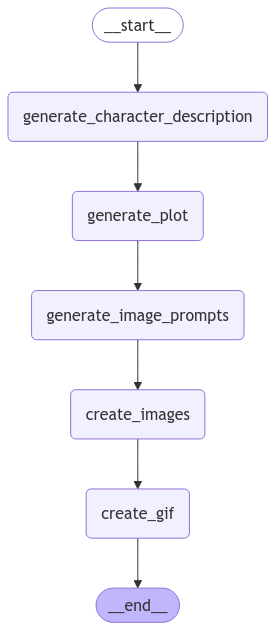

In [22]:
display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run Workflow Function

Define a function to run the workflow and display results.

In [23]:
async def run_workflow(query: str):
    """Run the LangGraph workflow and display results."""
    initial_state = {
        "messages": [],
        "query": query,
        "plot": "",
        "character_description": "",
        "image_prompts": [],
        "image_urls": [],
        "gif_data": None
    }

    try:
        result = await app.ainvoke(initial_state)

        print("Character/Scene Description:")
        print(result["character_description"])

        print("\nGenerated Plot:")
        print(result["plot"])

        print("\nImage Prompts:")
        for i, prompt in enumerate(result["image_prompts"], 1):
            print(f"{i}. {prompt}")

        print("\nGenerated Image URLs:")
        for i, url in enumerate(result["image_urls"], 1):
            print(f"{i}. {url}")

        if result["gif_data"]:
            print("\nGIF generated successfully. Use the next cell to display or save it.")
        else:
            print("\nFailed to generate GIF.")
        
        return result
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

## Execute Workflow

Run the workflow with a sample query.

In [24]:
query = "A small girl holding a unicorn which is wavering his wings and flying amidst the clouds"
result = await run_workflow(query)

Character/Scene Description:
Main Character: The main character of this scene is a small girl. She is around 5-7 years old with bright, sparkling eyes full of wonder and innocence. Her hair is a chestnut brown, worn loose and flowing to her shoulders with soft waves. She is dressed in a simple pastel-colored, probably pink or lavender, dress that reaches just below her knees, adorned with tiny floral patterns. On her feet, she wears shiny Mary Jane shoes and white ankle socks. She carries an innocent smile on her face, a look of pure joy, and excitement that reflects her adventurous spirit.

Main Object: The main object in this scene is a magical unicorn. This unicorn is medium-sized, perfect for the small girl to hold. It has a glossy white coat that shimmers under the sunlight, and a long, spiraling horn at the center of its forehead. The horn is opalescent and seems to radiate a soft light. Its mane and tail are a rainbow of colors, flowing and wavy, giving an impression of untamed 

## Display and Save GIF

Display the generated GIF and provide an option to save it.

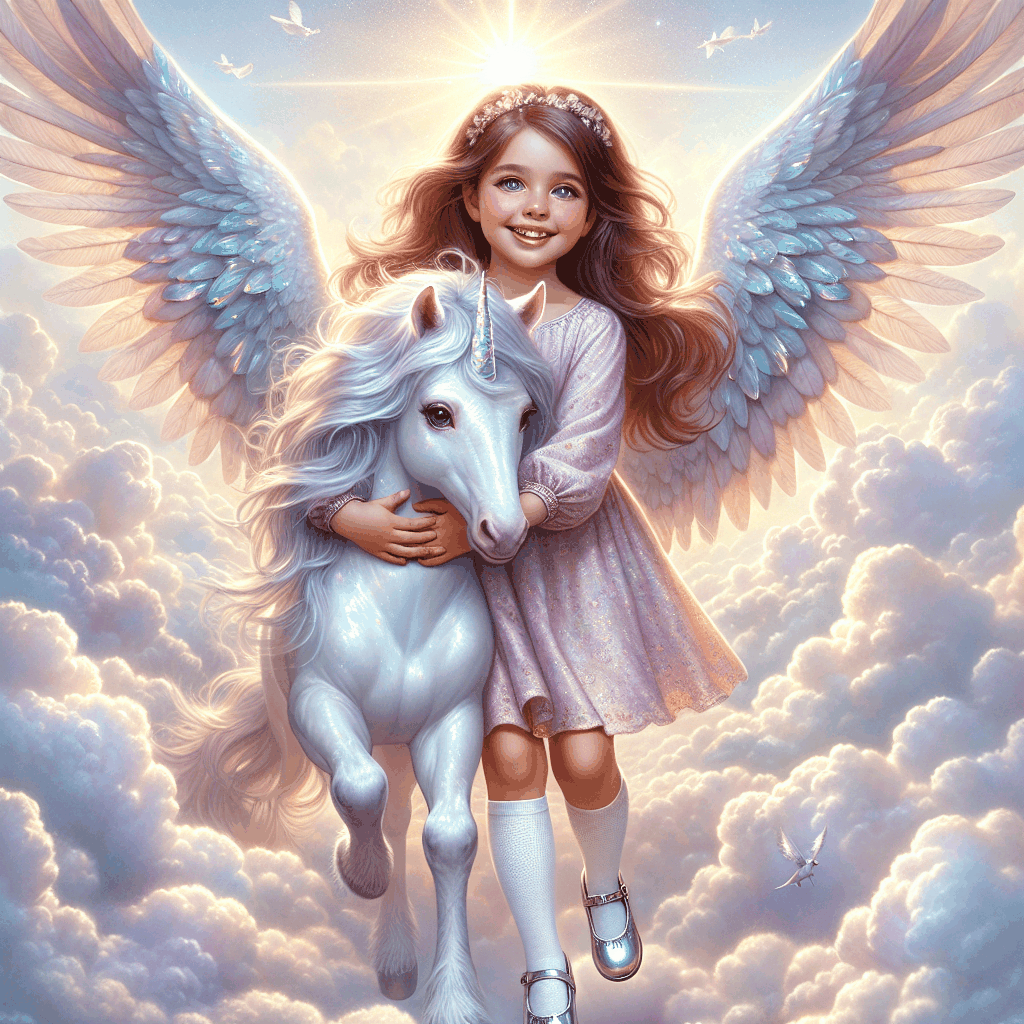

Do you want to save the GIF? (yes/no):  yes
Enter the filename to save the GIF (e.g., output.gif):  unicorm


GIF saved as unicorm.gif


In [25]:
if result and result["gif_data"]:
    # Display the GIF
    display(IPImage(data=result["gif_data"], format='gif'))
    
    # Ask if the user wants to save the GIF
    save_gif = input("Do you want to save the GIF? (yes/no): ").lower().strip()
    if save_gif == 'yes':
        filename = input("Enter the filename to save the GIF (e.g., output.gif): ").strip()
        if not filename.endswith('.gif'):
            filename += '.gif'
        with open(filename, 'wb') as f:
            f.write(result["gif_data"])
        print(f"GIF saved as {filename}")
    else:
        print("GIF not saved.")
else:
    print("No GIF data available to display or save.")